In [22]:
!pip install gpxpy

In [24]:
import gpxpy
import pandas as pd
import os

# Define the path to the GPX file
gpx_file_path = '/content/Standard_Chartered_Hanoi_Marathon.gpx'

# Check if the file exists
if not os.path.exists(gpx_file_path):
    print(f"Error: GPX file not found at {gpx_file_path}")
else:
    try:
        # Open and parse the GPX file
        with open(gpx_file_path, 'r') as gpx_file:
            gpx = gpxpy.parse(gpx_file)

        # Prepare a list to store track points
        track_points = []

        # Iterate through tracks, segments, and points
        for track in gpx.tracks:
            for segment in track.segments:
                for point in segment.points:
                    track_points.append({
                        'latitude': point.latitude,
                        'longitude': point.longitude,
                        'elevation': point.elevation,
                        'timestamp': point.time
                    })

        # Create a pandas DataFrame from the extracted track points
        df_gpx = pd.DataFrame(track_points)

        # Print the total number of points
        print(f"{len(df_gpx)} points")

    except Exception as e:
        print(f"An error occurred while processing the GPX file: {e}")

14153 points


In [25]:
!pip install geopy

In [27]:
from geopy.distance import geodesic
import numpy as np

# 1. Convert the 'timestamp' column to datetime objects
df_gpx['timestamp'] = pd.to_datetime(df_gpx['timestamp'])

# 2. Calculate the time difference in seconds between consecutive points
df_gpx['time_diff_seconds'] = df_gpx['timestamp'].diff().dt.total_seconds()

# 3. and 4. Calculate the Haversine distance in kilometers between consecutive points
# Using geopy's geodesic which is more accurate for long distances than Haversine
# It's also readily available and accounts for the Earth's ellipsoid shape.
# Using apply with lambda for row-wise calculation, it's efficient enough for this dataset size.

def calculate_geodesic_distance(row):
    if pd.isna(row['latitude_prev']) or pd.isna(row['longitude_prev']):
        return np.nan
    point1 = (row['latitude_prev'], row['longitude_prev'])
    point2 = (row['latitude'], row['longitude'])
    return geodesic(point1, point2).km

# Create shifted columns for previous latitude and longitude to calculate differences
df_gpx['latitude_prev'] = df_gpx['latitude'].shift(1)
df_gpx['longitude_prev'] = df_gpx['longitude'].shift(1)

df_gpx['distance_km'] = df_gpx.apply(calculate_geodesic_distance, axis=1)

# Drop the temporary shifted columns
df_gpx.drop(columns=['latitude_prev', 'longitude_prev'], inplace=True)

# 5. Calculate the pace in seconds per kilometer
# Handle division by zero or where distance is very small (near zero) by setting pace to NaN or 0
df_gpx['pace_sec_per_km'] = df_gpx.apply(lambda row:
    row['time_diff_seconds'] / row['distance_km'] if row['distance_km'] > 0 else np.nan,
    axis=1
)

# 6. Convert 'pace_sec_per_km' to minutes per kilometer
df_gpx['pace_min_per_km'] = df_gpx['pace_sec_per_km'] / 60

In [31]:
print(f"Initial number of points: {len(df_gpx)}")

# 1. Calculate Q1 and Q3 for 'pace_min_per_km', excluding NaN values
Q1_pace = df_gpx['pace_min_per_km'].quantile(0.25)
Q3_pace = df_gpx['pace_min_per_km'].quantile(0.75)

# 2. Calculate the Interquartile Range (IQR) for pace
IQR_pace = Q3_pace - Q1_pace

# 3. Define the lower and upper bounds for pace outlier detection
lower_bound_pace = Q1_pace - 1.5 * IQR_pace
upper_bound_pace = Q3_pace + 1.5 * IQR_pace

print(f"\n--- Pace Outlier Bounds ---")
print(f"Q1 (Pace): {Q1_pace:.2f} min/km")
print(f"Q3 (Pace): {Q3_pace:.2f} min/km")
print(f"IQR (Pace): {IQR_pace:.2f} min/km")
print(f"Lower bound for pace: {lower_bound_pace:.2f} min/km")
print(f"Upper bound for pace: {upper_bound_pace:.2f} min/km")

# Calculate Q1 and Q3 for 'distance_km', excluding NaN values
Q1_dist = df_gpx['distance_km'].quantile(0.25)
Q3_dist = df_gpx['distance_km'].quantile(0.75)

# Calculate the Interquartile Range (IQR) for distance
IQR_dist = Q3_dist - Q1_dist

# Define the lower and upper bounds for distance outlier detection
lower_bound_dist = Q1_dist - 1.5 * IQR_dist
upper_bound_dist = Q3_dist + 1.5 * IQR_dist

print(f"\n--- Distance Outlier Bounds ---")
print(f"Q1 (Distance): {Q1_dist:.2e} km")
print(f"Q3 (Distance): {Q3_dist:.2e} km")
print(f"IQR (Distance): {IQR_dist:.2e} km")
print(f"Lower bound for distance: {lower_bound_dist:.2e} km")
print(f"Upper bound for distance: {upper_bound_dist:.2e} km")

# 4. Create a new DataFrame by filtering out outliers and NaN values for both pace and distance
df_gpx_cleaned = df_gpx[
    (df_gpx['pace_min_per_km'] >= lower_bound_pace) &
    (df_gpx['pace_min_per_km'] <= upper_bound_pace) &
    (df_gpx['distance_km'] >= lower_bound_dist) &
    (df_gpx['distance_km'] <= upper_bound_dist)
].dropna(subset=['pace_min_per_km', 'distance_km']).copy()

# 5. Print the number of points removed and the number of remaining points
points_removed = len(df_gpx) - len(df_gpx_cleaned)
print(f"\nNumber of points removed as outliers or NaNs: {points_removed}")
print(f"Number of remaining points after outlier removal: {len(df_gpx_cleaned)}")

Initial number of points: 14153

--- Pace Outlier Bounds ---
Q1 (Pace): 4.78 min/km
Q3 (Pace): 6.08 min/km
IQR (Pace): 1.29 min/km
Lower bound for pace: 2.85 min/km
Upper bound for pace: 8.01 min/km

--- Distance Outlier Bounds ---
Q1 (Distance): 2.74e-03 km
Q3 (Distance): 3.48e-03 km
IQR (Distance): 7.41e-04 km
Lower bound for distance: 1.63e-03 km
Upper bound for distance: 4.59e-03 km

Number of points removed as outliers or NaNs: 1466
Number of remaining points after outlier removal: 12687


In [32]:
!pip install rdp

In [41]:
import numpy as np

# 2. Define the target maximum real-world error as 10 meters and the average Earth radius
target_error_meters = 10  # meters
earth_radius_meters = 6371000 # average Earth radius in meters

# 3. Calculate the angular distance in radians
# This approximates the distance at the equator. For more accuracy at a specific latitude,
# the radius of curvature at that latitude could be used, but for simplicity and given
# the small error, average radius is sufficient for this context.
angular_distance_radians = target_error_meters / earth_radius_meters

# 4. Convert this angular distance from radians to degrees to obtain the rdp_epsilon_degrees
optimal_rdp_epsilon = np.degrees(angular_distance_radians)

# 6. Print the calculated RDP epsilon (tolerance) in degrees
print(f"Target Maximum Real-World Error: {target_error_meters} meters")
print(f"Calculated Optimal RDP Epsilon (tolerance): {optimal_rdp_epsilon:.6f} degrees")

Target Maximum Real-World Error: 10 meters
Calculated Optimal RDP Epsilon (tolerance): 0.000090 degrees


In [42]:
import numpy as np
from rdp import rdp
import pandas as pd

# 1. Prepare the data for RDP: a NumPy array of [latitude, longitude] pairs
points_for_rdp = df_gpx_cleaned[['latitude', 'longitude']].values

# 2. Apply the RDP algorithm to get the simplified points (latitude, longitude pairs)
simplified_points_coords = rdp(points_for_rdp, algo="iter", epsilon=optimal_rdp_epsilon)

# Convert the simplified coordinates array to a set of tuples for efficient lookup
simplified_set = set(map(tuple, simplified_points_coords))

# Find the indices in the original df_gpx_cleaned that correspond to the simplified points
simplified_points_indices = []
for i, (lat, lon) in enumerate(points_for_rdp):
    if (lat, lon) in simplified_set:
        simplified_points_indices.append(i)

# 3. Create the simplified DataFrame by selecting points using the found indices
df_simplified_10m_error = df_gpx_cleaned.iloc[simplified_points_indices].copy()

# 4. Reset index for a clean DataFrame
df_simplified_10m_error.reset_index(drop=True, inplace=True)

print(f"RDP algorithm applied. Simplified track stored in df_simplified_10m_error.")
print(f"Number of points in df_gpx_cleaned: {len(df_gpx_cleaned)}")
print(f"Number of points in df_simplified_10m_error: {len(df_simplified_10m_error)}")

RDP algorithm applied. Simplified track stored in df_simplified_10m_error.
Number of points in df_gpx_cleaned: 12687
Number of points in df_simplified_10m_error: 264


In [43]:
# Install necessary libraries
!pip install matplotlib geopandas contextily

Now, I will convert the `df_simplified_10m_error` DataFrame into a GeoDataFrame, which is required for plotting with `geopandas` and `contextily`. I'll create `Point` geometries from the latitude and longitude columns and set the appropriate Coordinate Reference System (CRS).

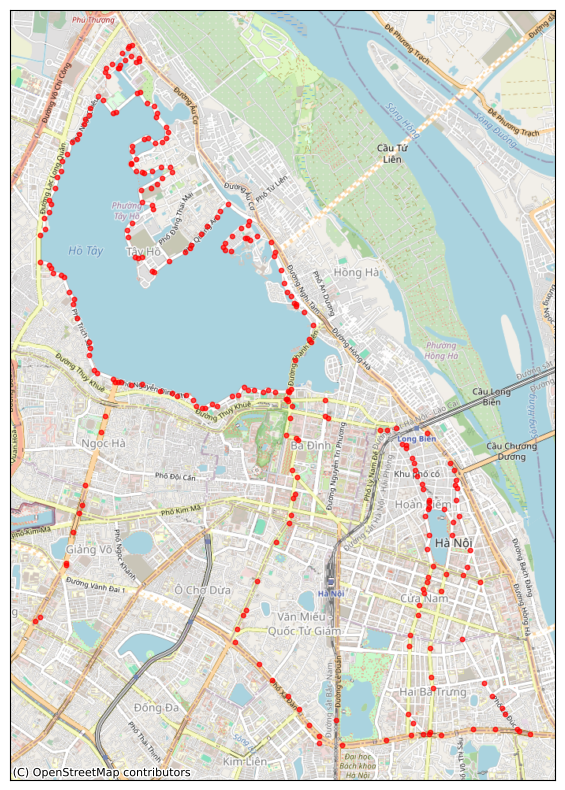

In [48]:
import geopandas
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as cx

# Create a GeoDataFrame from df_simplified_10m_error
geometry = [Point(xy) for xy in zip(df_simplified_10m_error['longitude'], df_simplified_10m_error['latitude'])]
gdf_simplified = geopandas.GeoDataFrame(df_simplified_10m_error, geometry=geometry)

# Set the Coordinate Reference System (CRS) to WGS84 (latitude/longitude)
gdf_simplified = gdf_simplified.set_crs('EPSG:4326')

# Reproject to Web Mercator (EPSG:3857) for compatibility with contextily basemaps
gdf_simplified_webmercator = gdf_simplified.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the simplified points
gdf_simplified_webmercator.plot(ax=ax, color='red', markersize=10, alpha=0.7)

# Add OpenStreetMap basemap
cx.add_basemap(ax, crs=gdf_simplified_webmercator.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

# Remove x and y ticks and their labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()

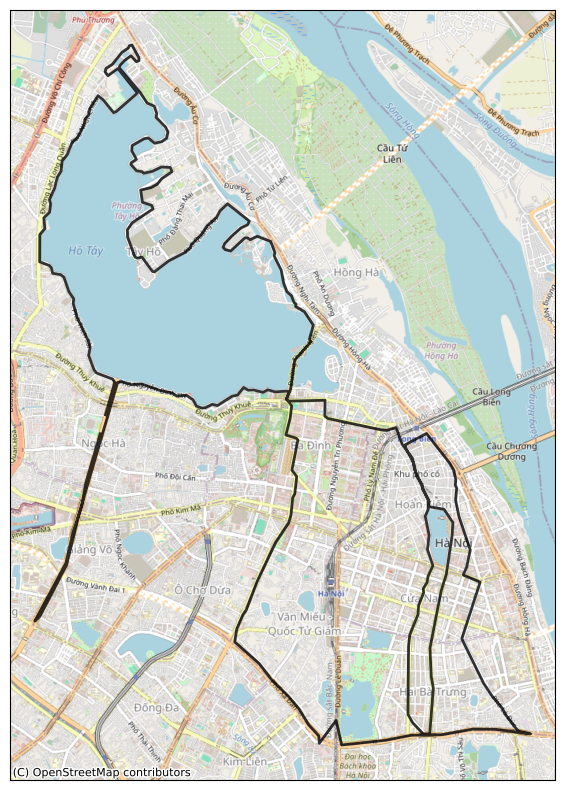

In [50]:
import geopandas as gpd
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import contextily as cx

# Create a LineString from your longitude/latitude columns
line = LineString(zip(df_simplified_10m_error['longitude'], df_simplified_10m_error['latitude']))

# Create a GeoDataFrame containing the single line
gdf_simplified = gpd.GeoDataFrame(index=[0], geometry=[line], crs='EPSG:4326')

# Reproject to Web Mercator for compatibility with contextily basemap
gdf_simplified_webmercator = gdf_simplified.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the line instead of points
gdf_simplified_webmercator.plot(ax=ax, color='black', linewidth=2, alpha=0.8)

# Add OpenStreetMap basemap
cx.add_basemap(ax, crs=gdf_simplified_webmercator.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

# Clean up axes
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()

In [52]:
df_simplified_10m_error_renamed = df_simplified_10m_error.rename(
    columns={'latitude': 'lat', 'longitude': 'lon'}
)

df_simplified_10m_error_renamed[['lat', 'lon']].to_csv('simplified_track.csv', index=False)